In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import mapclassify as mc
import geoplot as gplt
# from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
plt.rcParams.update({'font.size':27})

In [3]:
# === Leitura dos dados geográficos e CSVs ===
mapa_para = gpd.read_file('mapas/PA_Mesorregioes_2021.zip')
dat = pd.read_csv('mapas/mesoregiao_pa_2.csv')
dat['CD_MESO'] = dat['CD_MESO'].astype(str)  # Garantir que CD_MESO seja string para merge correto

# === Função para gerar GeoDataFrame para um ano específico ===
def gerar_mapa_mesorregiao(mapa, base, ano):
    """
    Agrupa e faz merge entre o shapefile da mesorregião do Pará e os dados de abstenção por ano.
    """
    colunas = [f'First day of the {ano} exam', f'Second day of the {ano} exam']
    resumo = (
        base.groupby('CD_MESO')[colunas]
            .mean()
            .reset_index()
    )
    return mapa.merge(resumo, on='CD_MESO')

# === Criar os mapas por ano ===
mapa_meso_2019 = gerar_mapa_mesorregiao(mapa_para, dat, 2019)
mapa_meso_2020 = gerar_mapa_mesorregiao(mapa_para, dat, 2020)
mapa_meso_2021 = gerar_mapa_mesorregiao(mapa_para, dat, 2021)
mapa_meso_2022 = gerar_mapa_mesorregiao(mapa_para, dat, 2022)

# === Leitura do CSV complementar atualizado ===
dat_update = pd.read_csv('mapas/mesoregiao_pa_2 - Edição.csv', sep=',')
df = dat_update[dat_update['Test day'].str.strip() == 'Second day']  # Remover espaços se existirem

In [4]:
df['Meso-Regions'].values

array(['Lower Amazon', 'Marajó', 'Metropolitan Area', 'Northeastern',
       'Southwest', 'Southeast', 'Lower Amazon', 'Marajó',
       'Metropolitan Area', 'Northeastern', 'Southwest', 'Southeast',
       'Lower Amazon', 'Marajó', 'Metropolitan Area', 'Northeastern',
       'Southwest', 'Southeast', 'Lower Amazon', 'Marajó',
       'Metropolitan Area', 'Northeastern', 'Southwest', 'Southeast'],
      dtype=object)

C:\Users\sandi\miniconda3\envs\geo-env\lib\site-packages\geoplot\geoplot.py:982: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


<Figure size 640x480 with 0 Axes>

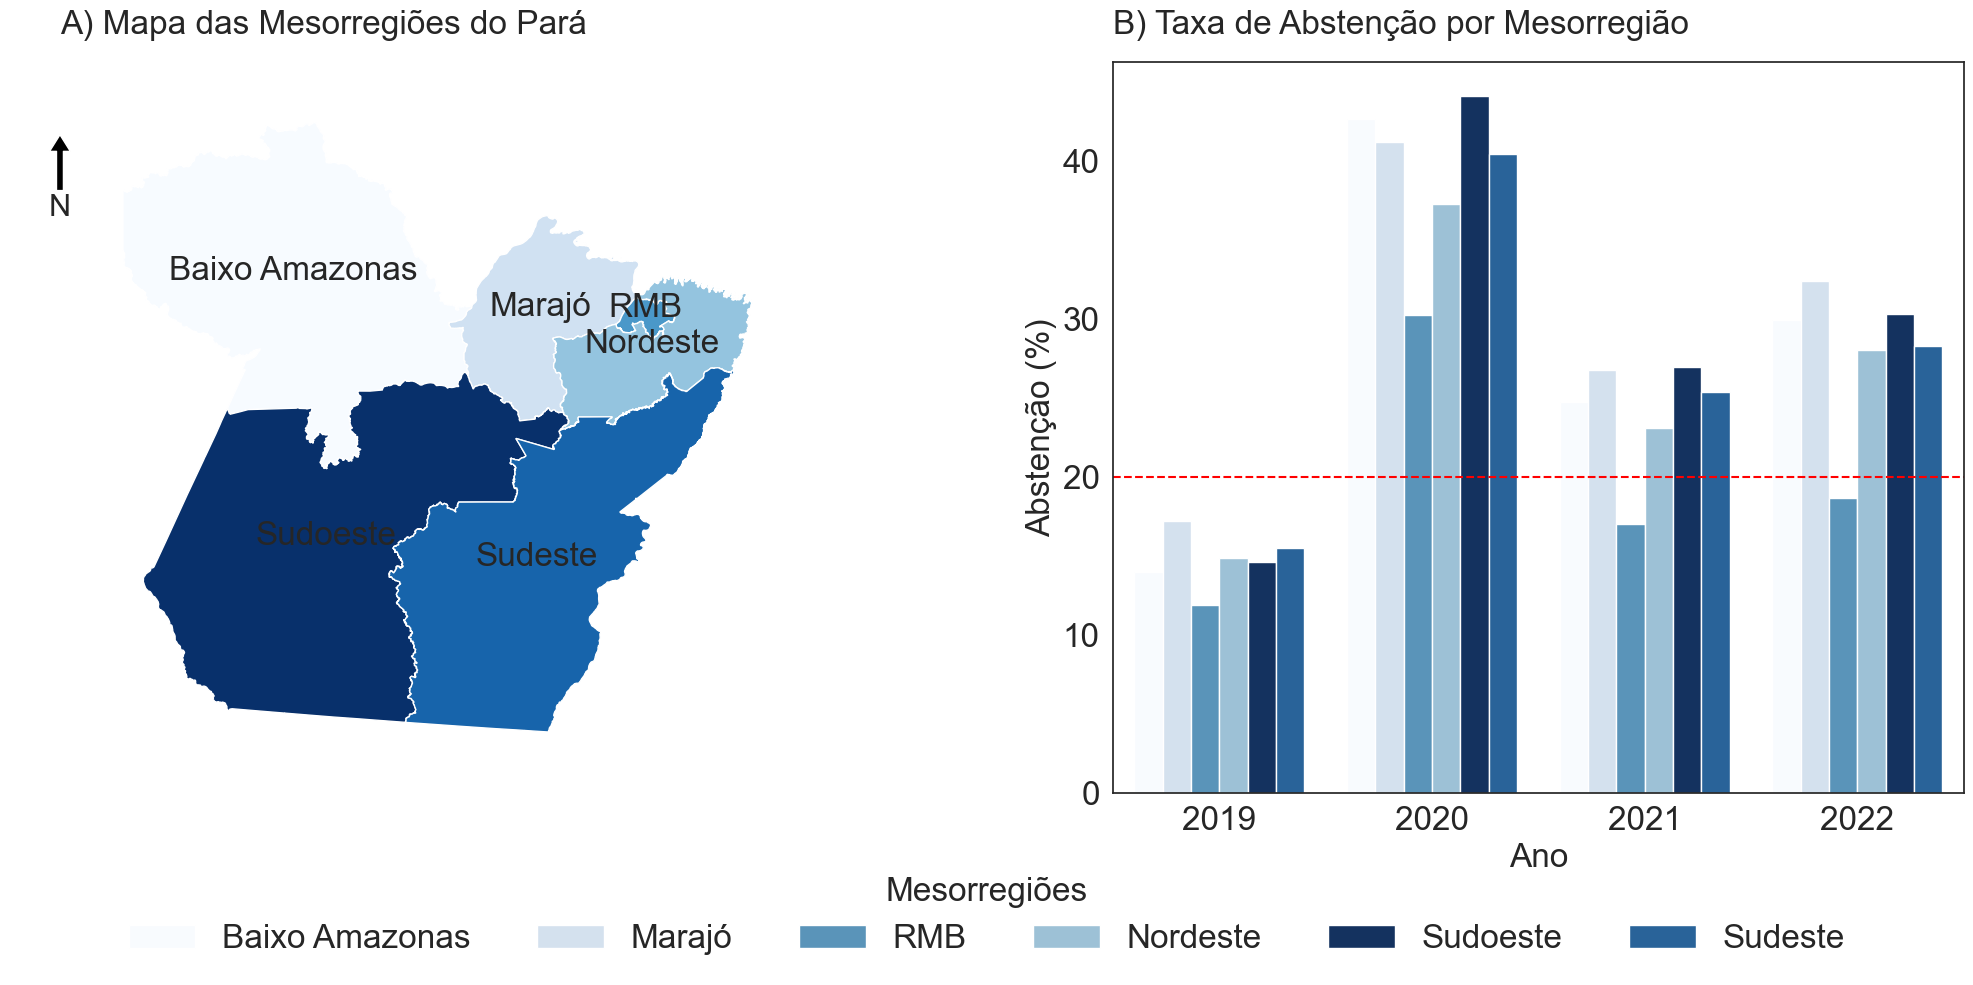

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import geoplot as gplt
import pandas as pd
import matplotlib.colors as mcolors

# Estilo visual
sns.set_theme(style="white", palette="pastel")
sns.despine()

# Leitura dos dados
mapa_mesorregioes = gpd.read_file('mapas/PA_Mesorregioes_2021.zip')
df = pd.read_csv('mapas/mesoregiao_pa_2 - Edição.csv')
df = df[df['Test day'] == 'Second day '].copy()

# Tradução das mesorregiões
traducao_meso = {
    "Metropolitan Area": "RMB",
    "Northeastern": "Nordeste",
    "Southwest": "Sudoeste",
    "Southeast": "Sudeste",
    "Marajó": "Marajó",
    "Lower Amazon": "Baixo Amazonas"
}

traducao_meso2 = {
    "Metropolitana de Belém": "RMB",
    "Nordeste Paraense": "Nordeste",
    "Sudoeste Paraense": "Sudoeste",
    "Sudeste Paraense": "Sudeste",
    "Marajó": "Marajó",
    "Baixo Amazonas": "Baixo Amazonas"
}

df['Meso-Regions'] = df['Meso-Regions'].replace(traducao_meso)
mapa_mesorregioes['NM_MESO'] = mapa_mesorregioes['NM_MESO'].replace(traducao_meso2)

# Geração de cores únicas por região
todas_regioes = sorted(df['Meso-Regions'].unique())
cmap = plt.cm.get_cmap('Blues', len(todas_regioes))
color_mapping = {reg: mcolors.rgb2hex(cmap(i)) for i, reg in enumerate(todas_regioes)}

# Criar figura
fig, axes = plt.subplots(1, 2, figsize=(22, 10), gridspec_kw={'width_ratios': [1.5, 1]})

# Função para adicionar bússola
def adicionar_bussola(ax, x=0.0, y=0.9):
    ax.annotate('N', xy=(x, y), xytext=(x, y - 0.1),
                arrowprops=dict(facecolor='black', width=5, headwidth=15),
                ha='center', va='center', fontsize=22, xycoords=ax.transAxes)

# === MAPA ===
gplt.choropleth(
    mapa_mesorregioes,
    hue='NM_MESO',
    cmap='Blues',
    legend=False,
    ax=axes[0]
)
axes[0].set_title("A) Mapa das Mesorregiões do Pará", fontsize=24, pad=20, loc='left')
mapa_mesorregioes.apply(lambda x: axes[0].annotate(text=x['NM_MESO'], fontsize=24,
                                                   xy=x.geometry.centroid.coords[0],
                                                   ha='center'), axis=1)
adicionar_bussola(axes[0])

# === GRÁFICO DE BARRAS ===
sns.barplot(
    data=df,
    x='Year',
    y='Abstention rate',
    hue='Meso-Regions',
    palette=color_mapping,
    ax=axes[1],
    dodge=True
)

axes[1].axhline(y=20, color='red', linestyle='--', linewidth=1.5)
axes[1].set_title("B) Taxa de Abstenção por Mesorregião", fontsize=24, pad=20, loc='left')
axes[1].set_xlabel("Ano", fontsize=24)
axes[1].set_ylabel("Abstenção (%)", fontsize=24)
axes[1].tick_params(axis='x', labelsize=24)
axes[1].tick_params(axis='y', labelsize=24)
axes[1].legend_.remove()

# === LEGENDA UNIFICADA (TRADUZIDA) ===
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(
    handles, labels,
    title="Mesorregiões",
    fontsize=24,
    title_fontsize=24,
    loc='lower center',
    ncol=len(labels),  # uma legenda por coluna
    frameon=False
)

# Finalização
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.savefig("mapa_abstencao_mesoregiao_pt.png", format="png", dpi=300)
plt.show()